In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping, ModelCheckpoint
from gensim.models.keyedvectors import KeyedVectors
 
import matplotlib.pyplot as plt
%matplotlib inline 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
EMBEDDING_FILE = 'crawl-300d-2M.vec'

train = pd.read_csv('train_pre2.csv')
test = pd.read_csv('test_pre2.csv')
submission = pd.read_csv('sample_submission.csv')

In [3]:
X_train = train["comment_text"].fillna("fillna").values
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
X_test = test["comment_text"].fillna("fillna").values

In [4]:
X_train[0]

'explanation,why,the,edits,made,under,my,username,hardcore,metallica,fan,were,reverted,they,were,not,vandalisms,just,closure,on,some,gas,after,i,voted,at,new,york,dolls,fac,and,please,do,not,remove,the,template,from,the,talk,page,since,i,am,retired,now,89,205,38,27'

In [5]:
max_features = 100000
max_len = 200
embed_size = 300

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train) + list(X_test))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [6]:
x_train = sequence.pad_sequences(X_train, maxlen=max_len)
x_test = sequence.pad_sequences(X_test, maxlen=max_len)

In [7]:
len(x_train)

159571

In [8]:
len(y_train)

159571

In [9]:
word_index = tokenizer.word_index

In [10]:
nb_words = min(max_features, len(word_index))

In [11]:
len(word_index)

394762

In [12]:
model = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=False)

In [13]:
def get_embeddings():
    embedding_matrix = np.zeros((nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = model[word] if word in model else None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [14]:
embedding_matrix = get_embeddings()

In [15]:
embedding_matrix.shape

(100000, 300)

In [16]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data


    def on_epoch_end(self, epoch, logs = {}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.4f \n" % (epoch+1, score))


In [17]:
filter_sizes = [3,4,5]
num_filters = 32

In [36]:
def get_model(drop):    
    inp = Input(shape=(max_len, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(drop)(x)
    x = Reshape((max_len, embed_size, 1))(x)
    
    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embed_size), kernel_initializer='normal',activation='elu')(x)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embed_size), kernel_initializer='normal',activation='elu')(x)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embed_size), kernel_initializer='normal',activation='elu')(x)
    
    maxpool_0 = MaxPool2D(pool_size=(max_len - filter_sizes[0] + 1, 1),strides=(1,1), padding='valid')(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(max_len - filter_sizes[1] + 1, 1),strides=(1,1), padding='valid')(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(max_len - filter_sizes[2] + 1, 1),strides=(1,1), padding='valid')(conv_2)
        
    concatenated_tensor  = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])   
    flatten  = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
        
    output = Dense(6, activation="sigmoid")(dropout)
    
    model = Model(inputs=inp, outputs=output)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

这里损失函数选择了binary_crossentropy而不是categorical_crossentropy，参考了https://blog.csdn.net/leyounger/article/details/78949709 ，按照文中说明，恶毒评论虽然是一个多标签的分类，但是因为每个数据都可能属于某个，或多个，或0个标签，所以我们可以认为这是一个数据属于任意数量的类别，或者不属于其中的二分类，这样所有类的概率之和则为1。

In [43]:
batch_size = 128
epochs = 3
drop_list = [0.3,0.5,0.7]
ls_list = []
ac_list = []

In [44]:
X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=18)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)
for drop in drop_list:
    model = get_model(drop)
    print('drop:',drop)
    hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),callbacks=[RocAuc],verbose=2)
    ls_list.append(hist.history['val_loss'])
    ac_list.append(hist.history['val_acc'])

drop: 0.3
Train on 119678 samples, validate on 39893 samples
Epoch 1/3
 - 74s - loss: 0.0694 - acc: 0.9771 - val_loss: 0.0462 - val_acc: 0.9831

 ROC-AUC - epoch: 1 - score: 0.9826 

Epoch 2/3
 - 71s - loss: 0.0460 - acc: 0.9830 - val_loss: 0.0443 - val_acc: 0.9836

 ROC-AUC - epoch: 2 - score: 0.9864 

Epoch 3/3
 - 72s - loss: 0.0391 - acc: 0.9851 - val_loss: 0.0454 - val_acc: 0.9831

 ROC-AUC - epoch: 3 - score: 0.9860 

drop: 0.5
Train on 119678 samples, validate on 39893 samples
Epoch 1/3
 - 73s - loss: 0.0860 - acc: 0.9726 - val_loss: 0.0498 - val_acc: 0.9822

 ROC-AUC - epoch: 1 - score: 0.9769 

Epoch 2/3
 - 72s - loss: 0.0542 - acc: 0.9812 - val_loss: 0.0467 - val_acc: 0.9832

 ROC-AUC - epoch: 2 - score: 0.9840 

Epoch 3/3
 - 72s - loss: 0.0491 - acc: 0.9824 - val_loss: 0.0463 - val_acc: 0.9830

 ROC-AUC - epoch: 3 - score: 0.9847 

drop: 0.7
Train on 119678 samples, validate on 39893 samples
Epoch 1/3
 - 73s - loss: 0.1361 - acc: 0.9598 - val_loss: 0.0628 - val_acc: 0.9801

 

In [47]:
# val_loss学习曲线
color_list = ['tab:blue', 'tab:orange', 'tab:green']

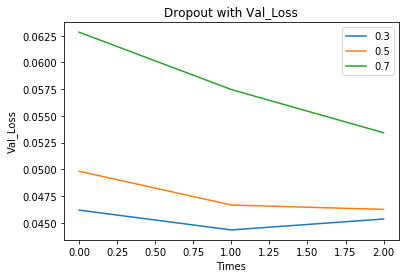

In [48]:
for i in range(len(ls_list)):
    plt.plot(ls_list[i], color = color_list[i], label = drop_list[i])
plt.title('Dropout with Val_Loss')
plt.xlabel('Times')
plt.ylabel('Val_Loss')
plt.legend()
plt.show()

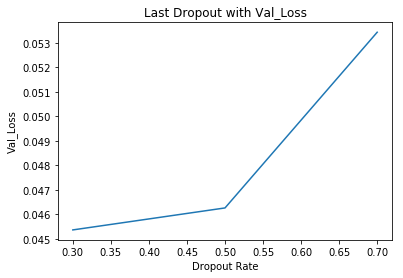

In [49]:
plt.plot(drop_list, [ x[-1:] for x in ls_list ])
plt.title('Last Dropout with Val_Loss')
plt.xlabel('Dropout Rate')
plt.ylabel('Val_Loss')
plt.show()

可以看出0.3的时候效果最好，然后我们再在embedding层进行加上trainable = True来对词向量进行稍稍的训练

In [50]:
def final_model():    
    inp = Input(shape=(max_len, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = True)(inp)
    x = SpatialDropout1D(0.3)(x)
    x = Reshape((max_len, embed_size, 1))(x)
    
    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embed_size), kernel_initializer='normal',activation='elu')(x)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embed_size), kernel_initializer='normal',activation='elu')(x)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embed_size), kernel_initializer='normal',activation='elu')(x)
    
    maxpool_0 = MaxPool2D(pool_size=(max_len - filter_sizes[0] + 1, 1),strides=(1,1), padding='valid')(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(max_len - filter_sizes[1] + 1, 1),strides=(1,1), padding='valid')(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(max_len - filter_sizes[2] + 1, 1),strides=(1,1), padding='valid')(conv_2)
        
    concatenated_tensor  = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])   
    flatten  = Flatten()(concatenated_tensor)
    dropout = Dropout(0.3)(flatten)
        
    output = Dense(6, activation="sigmoid")(dropout)
    
    model = Model(inputs=inp, outputs=output)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [52]:
model_1 = final_model( )
file_path = "textcnn_weights_base2.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
early = EarlyStopping(monitor="val_loss", mode="auto", patience=10)
callbacks_list = [checkpoint, early, RocAuc]

In [53]:
history = model_1.fit(X_tra, y_tra, batch_size=batch_size, epochs=10, validation_data=(X_val, y_val),
                 callbacks=callbacks_list)

Train on 119678 samples, validate on 39893 samples
Epoch 1/10
119678/119678 [==============================] - 75s 626us/step - loss: 0.0745 - acc: 0.9751 - val_loss: 0.0475 - val_acc: 0.9830

Epoch 00001: val_loss improved from inf to 0.04754, saving model to textcnn_weights_base2.best.hdf5

 ROC-AUC - epoch: 1 - score: 0.9817 

Epoch 2/10
119678/119678 [==============================] - 73s 609us/step - loss: 0.0463 - acc: 0.9831 - val_loss: 0.0441 - val_acc: 0.9837

Epoch 00002: val_loss improved from 0.04754 to 0.04409, saving model to textcnn_weights_base2.best.hdf5

 ROC-AUC - epoch: 2 - score: 0.9855 

Epoch 3/10
119678/119678 [==============================] - 73s 610us/step - loss: 0.0393 - acc: 0.9852 - val_loss: 0.0449 - val_acc: 0.9834

Epoch 00003: val_loss did not improve from 0.04409

 ROC-AUC - epoch: 3 - score: 0.9860 

Epoch 4/10
119678/119678 [==============================] - 73s 610us/step - loss: 0.0339 - acc: 0.9871 - val_loss: 0.0457 - val_acc: 0.9836

Epoch 000

第三个epoch就不更新了，可见10次有点多余，不过用了提前停止，保存了最优参数

In [54]:
model.load_weights(file_path)

In [55]:
y_pred = model.predict(x_test)
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission-textcnn2.csv', index=False)

In [ ]:
cv_id = random.